#Stock Prices Forecasting with advanced Machine Learning techniques

In [ ]:
# https://medium.com/@palajnc/stock-prices-forecasting-with-advanced-machine-learning-techniques-python-lighgbm-time-series-7dbc2116e54b

!pip -q install yfinance
!pip -q install ta

  Preparing metadata (setup.py) ... done


/tmp/ipython-input-895941467.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start="2000-01-01", end = "2025-08-20", interval = "1d")
[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2000-01-03    0.840094    0.844316    0.763168    0.787090  535796800
2000-01-04    0.769266    0.830244    0.759415    0.812420  512377600
2000-01-05    0.780523    0.829775    0.773018    0.778646  778321600
2000-01-06    0.712977    0.803038    0.712977    0.796471  767972800
2000-01-07    0.746751    0.758008    0.716731    0.724235  460734400
...                ...         ...         ...         ...        ...
2025-08-13  233.330002  235.000000  230.429993  231.070007   69878500
2025-08-14  232.779999  235.119995  230.850006  234.059998   51916300
2025-08-15  231.589996  234.279999  229.339996  234.000000   56038700
2025-08-18  230.889999  233.119995  230.110001  231.699997   37476200
2025-08-19  230.559998  232.869995  229.350006  231.279999   39402600

[6446 rows x 5 colu

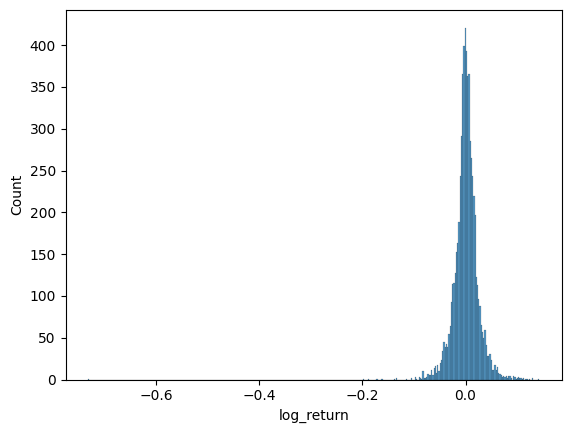

<Figure size 640x480 with 0 Axes>

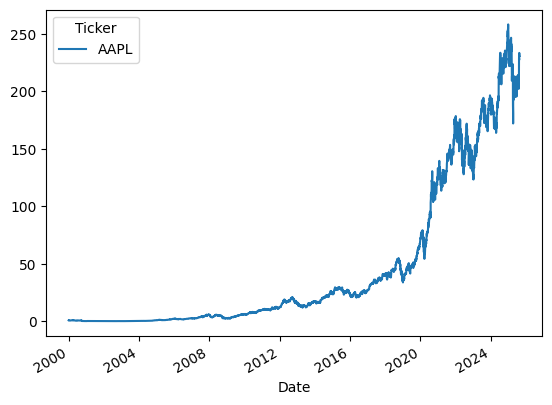

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit


class CFG:
  n_splits = 5
  forecast_days = 90
  gap = 2
  state = 0
  prune_trials = 7
  steps_prune = 100
  trials = 100

  lags = [5,10, 25, 50]


df = yf.download('AAPL', start="2000-01-01", end = "2025-08-20", interval = "1d")
print(df)

df['log_return']=np.log(df['Close']/df['Close'].shift(1))
sns.histplot(df['log_return'])
plt.show()
plt.clf()
df['Close'].plot()
plt.show()
plt.clf()

Observation:

Distribution of Log Returns:

This histogram visualizes the distribution of the log returns.

*  Shape: The distribution looks approximately normal but with a high peak around zero.
*   Skewness/Kurtosis: The high peak suggests that the distribution might have high kurtosis (more extreme values than a normal distribution). It may also have some skewness. This is typical for stock returns.
*   Range: Most of the returns are close to zero, but there are some returns that are further away from zero.



AAPL Stock Price Over Time:

This plot shows the historical stock price of Apple (AAPL) from 2000 to 2025.
* Trend: There's a clear upward trend, especially noticeable after 2010, indicating significant growth in Apple's stock price.
* Volatility: The volatility (price fluctuations) seems to increase in recent years (2020 onwards).

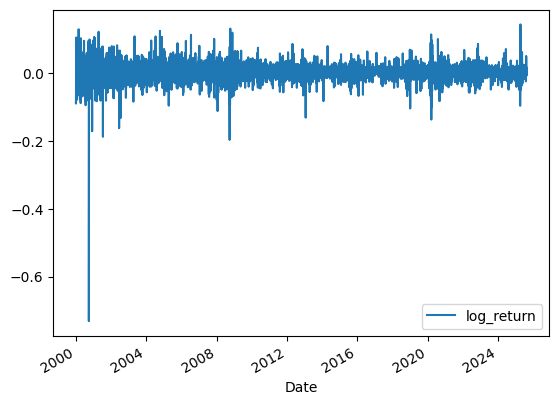

In [ ]:
df.plot(y='log_return')
plt.show()

Log Returns Time Series: This plot shows the log returns of Apple's stock over time.

*  Stationarity: The log returns seem to fluctuate around zero, which is a good sign for stationarity (a desirable property for time series analysis).
*  Outliers: There are some noticeable outliers, particularly a large negative return around 2001-2003. These could correspond to significant market events or company-specific news.
*  Volatility Clusters: There might be periods of higher and lower volatility, which is common in financial time series.

Potential Insights and Further Analysis:

*  Volatility Analysis: Investigate the volatility of AAPL stock over different periods. Are there specific events that correlate with increased volatility?
*  Tail Risk: The distribution of log returns suggests the presence of "fat tails," meaning extreme events are more likely than predicted by a normal distribution. This is important for risk management.
*  Stationarity Tests: Formally test the stationarity of the log returns using tests like the Augmented Dickey-Fuller (ADF) test.
*  Model Building: The data could be used to build a time series model (e.g., ARIMA, GARCH) to forecast future returns or assess risk.
*  Event Analysis: Investigate the causes of the outliers in the log returns.

In [ ]:
#Due to different volatility increases with time. Consideration: economics cycle, volatility regime
# best to study the return for the past 5 years. Better solution?
# Define a target：90-days lead log returns
df['target'] = df['log_return'].shift(-CFG.forecast_days)

#Feature Engineering

Here's a summary of the feature engineering techniques for time series data, presented in bullet points:

*   **Lag Features:** Use past values of the time series as predictors.
*   **Moving Averages:** Smooth out short-term fluctuations to highlight longer-term trends, including SMA and EMA.
*   **Technical Indicators:** Mathematical calculations based on historical price, volume, or open interest, such as RSI, MACD, and Bollinger Bands.
*  * **Fundamental Indicators:** Based on financial statements and economic indicators like P/E ratio, EPS, and Dividend Yield.
*  * **Combination of Features:** Create new features by combining existing ones, such as the ratio of two moving averages.
*   **Aggregations:** Utilize statistical measures like mean and standard deviation over different time periods to provide additional information to the model.
*  * **Stationary Data:** Address LightGBM's limitation in capturing trends by using log-returns prediction or a hybrid model, especially when future data exceeds previous data.

In [ ]:
import ta
#Purpose: This function creates lag features for the log_return column of the input DataFrame. \
#Lag features are simply past values of a time series used as predictors.
def create_lag(input_df):
  for lag in CFG.lags:
    input_df[f'lag_{lag}']=input_df['log_return'].shift(lag)
  return input_df

#This function calculates moving averages of the log_return column.
# Moving averages smooth out short-term fluctuations and highlight trends.
def create_ma(input_df):
  for lag in CFG.lags:
    input_df[f'ma_{lag}']=input_df['log_return'].rolling(window=lag).mean()
  return input_df


#Revisit: Explain it?

def create_technical(input_df):
  #calculates the Relative Strength Index (RSI) of the log_return column.
  # RSI is a momentum oscillator that measures the speed and change of price movements.
  input_df['rsi']=ta.momentum.rsi(input_df['log_return'])

  input_df['macd']=ta.trend.macd(input_df['log_return'])

  for lag in CFG.lags:
    input_df[f'ema_{lag}'] = ta.trend.ema_indicator(input_df['log_return'], lag)
  input_df['h_bollinger'] = ta.volatility.bollinger_hband(input_df['log_return'])
  input_df['l_bollinger'] = ta.volatility.bollinger_lband(input_df['log_return'])

  return input_df

# Revisit: are you calculating the aggregate data for each quarter of each year or the aggregate data for each four quarters of all years?
def create_agg(input_df):
  #Create seasonal aggregations
  input_df['quarter'] = input_df.index.quarter

  means=input_df.groupby('quarter')['log_return'].mean()
  # In essence, this line of code looks up the value in each row of the quarter column within the means dictionary/Series, and then puts the corresponding value from means into the new q_mean column for that row.
  std=input_df.groupby('quarter')['log_return'].std()
  skew=input_df.groupby('quarter')['log_return'].skew()

  input_df['q_mean'] = input_df['quarter'].map(means)
  input_df['q_std'] = input_df['quarter'].map(std)
  input_df['q_skew'] = input_df['quarter'].map(skew)

  return input_df

#This function orchestrates the creation of all the features by calling the other feature engineering functions.
def create_features(input_df):
  output_df = create_lag(input_df.copy())
  output_df = create_ma(output_df)
  output_df = create_technical(output_df)
  output_df = create_agg(output_df)
  return output_df



In [ ]:
# This dataset will be used to perform the machine learning
df_ml = df.copy()[['log_return','target']][~df['log_return'].isna()]
df_ml = create_features(df_ml)
print(df_ml)

Price      log_return    target     lag_5    lag_10    lag_25    lag_50  \
Ticker                                                                    
Date                                                                      
2000-01-04  -0.088077  0.045746       NaN       NaN       NaN       NaN   
2000-01-05   0.014527 -0.063533       NaN       NaN       NaN       NaN   
2000-01-06  -0.090514  0.045365       NaN       NaN       NaN       NaN   
2000-01-07   0.046281 -0.041660       NaN       NaN       NaN       NaN   
2000-01-10  -0.017744 -0.006184       NaN       NaN       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
2025-08-13   0.015897       NaN  0.049653 -0.010563  0.005366  0.004223   
2025-08-14  -0.002360       NaN  0.031299 -0.007105  0.005997  0.007754   
2025-08-15  -0.005125       NaN  0.041485 -0.025321 -0.005902 -0.002216   
2025-08-18  -0.003027       NaN -0.008372  0.004782 -0.012102 -0.010856   
2025-08-19  -0.001430    

#Train and test split
The train/test split is valid because it's a time series forecasting problem, which necessitates a sequential split to prevent data leakage and ensure the model is trained on past data to predict future data. The document specifically mentions that the split cannot be completely random, as time series models use past information to forecast future information. Using TimeSeriesSplit ensures that the model does not see future data during training, which is crucial for a realistic evaluation of the model's performance.

In [ ]:
train_ds = df_ml[~df_ml['target'].isna()]
test_ds =  df_ml[df_ml['target'].isna()]

print(f'Train dataset shape: {train_ds.shape}')
print(f'Train dataset shape: {train_ds.shape}')

Train dataset shape: (6355, 22)
Train dataset shape: (6355, 22)
